In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns

In [4]:
# Load and prepare your data
data_dir_scattered = "/Users/dirkkuiper/Documents/MacBookProDocuments/University/Thesis/Rep_Learn_FRB/simulated_scattered_bursts"
data_dir_simple = "/Users/dirkkuiper/Documents/MacBookProDocuments/University/Thesis/Rep_Learn_FRB/simulated_simple_bursts"

# Load the data from both directories into separate arrays
data_scattered = []
data_simple = []

for filename in os.listdir(data_dir_scattered):
    if filename.endswith(".npy"):
        data_scattered.append(np.load(os.path.join(data_dir_scattered, filename)))

for filename in os.listdir(data_dir_simple):
    if filename.endswith(".npy"):
        data_simple.append(np.load(os.path.join(data_dir_simple, filename)))

data_scattered = np.array(data_scattered).reshape(-1, 1024 * 512)[0:100]
data_simple = np.array(data_simple).reshape(-1, 1024 * 512)[0:100]

In [5]:
print(data_scattered.shape)

(100, 524288)


In [6]:
# Combine the two datasets into one
combined_data = np.concatenate((data_scattered, data_simple), axis=0)

# Reshape the combined data for PCA
combined_data_2d = combined_data.reshape(-1, 1024 * 512)

combined_data_2d.shape

(200, 524288)

In [7]:
# Apply PCA to the combined data
n_components = 2  # You can adjust the number of components as needed
pca = PCA(n_components=n_components)
fit = pca.fit(combined_data_2d)
transformed_fit = pca.fit_transform(combined_data_2d)



In [8]:
pca1 = pca.transform(data_scattered)
pca2 = pca.transform(data_simple)

In [9]:
# Load the scattering times from the CSV files
data_info_simple = pd.read_csv("simulated_simple_bursts/simulated_simple_bursts.csv")
scattering_times_simple = data_info_simple['tau'].to_numpy()

data_info_scattered = pd.read_csv("simulated_scattered_bursts/simulated_scattered_bursts.csv")
scattering_times_scattered = data_info_scattered['tau'].to_numpy()

FileNotFoundError: [Errno 2] No such file or directory: 'simulated_simple_bursts/simulated_simple_bursts.csv'

ValueError: 'c' argument has 1000 elements, which is inconsistent with 'x' and 'y' with size 100.

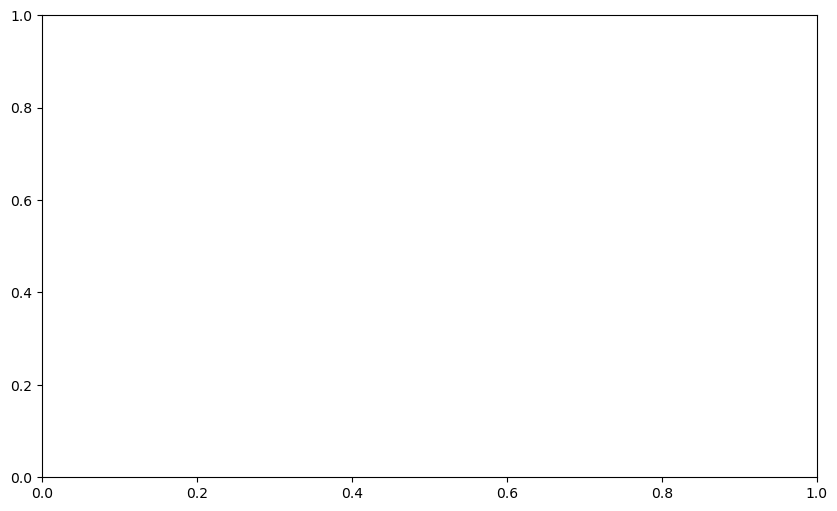

In [21]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create a scatter plot where points are colored by scattering times
scatter =plt.scatter(pca1[:, 0], pca1[:, 1], c=scattering_times_scattered, cmap='viridis', label='scattered', marker='o', s=20)
plt.scatter(pca2[:, 0], pca2[:, 1], c='r', label='simple', marker='s', s=20)

# Set axis labels
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Set a title for the plot
plt.title('PCA Results')

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Scattering Time')

# Display a legend to differentiate the two datasets
plt.legend()

# Show the plot
plt.show()


In [22]:
# Apply PCA to the combined data
n_components = 3  # You can adjust the number of components as needed
pca = PCA(n_components=n_components)
fit = pca.fit(combined_data_2d)
transformed_fit = pca.fit_transform(combined_data_2d)

pca1 = pca.transform(data_scattered)
pca2 = pca.transform(data_simple)

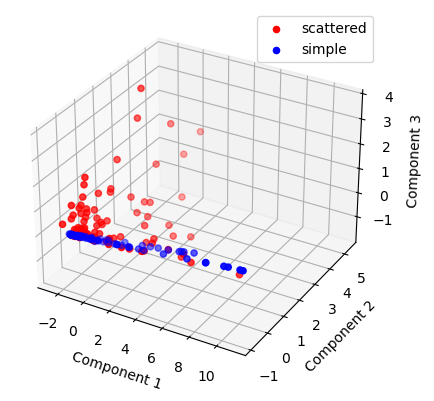

In [23]:
# PCA results pca1 and pca2 with three components each
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for pca1
ax.scatter(pca1[:, 0], pca1[:, 1], pca1[:, 2], c='r', label='scattered')

# Scatter plot for pca2
ax.scatter(pca2[:, 0], pca2[:, 1], pca2[:, 2], c='b', label='simple')

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

plt.legend()
plt.show()

## Look at the PCA representation for each component

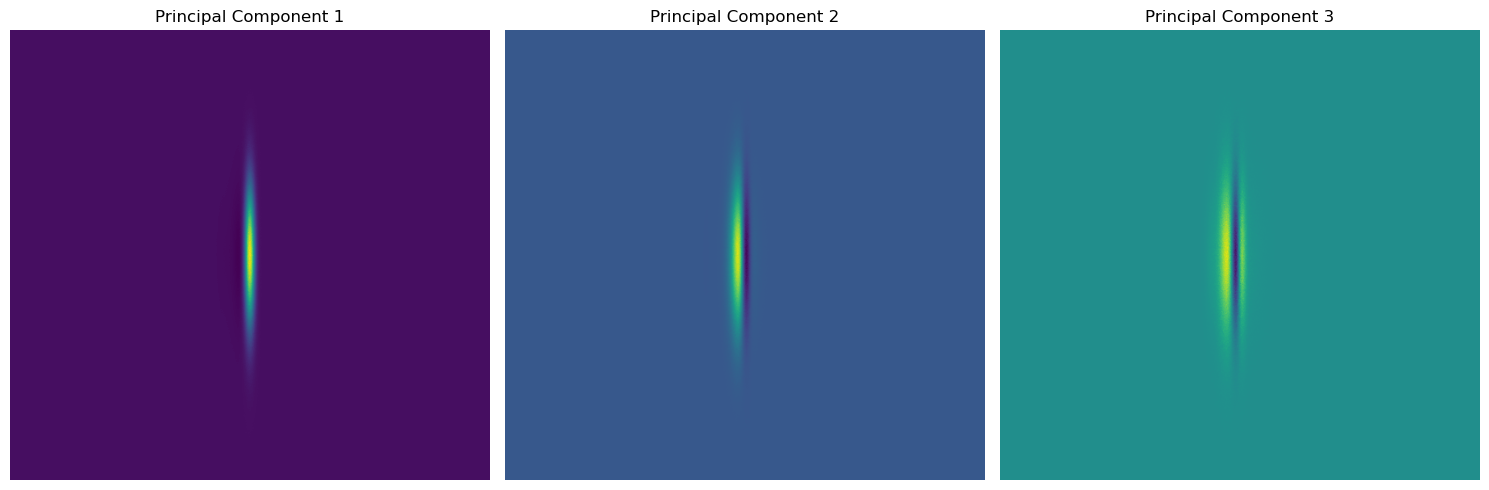

In [24]:
# Get the principal components
principal_components = pca.components_

# Create a subplot for each principal component
n_cols = 3  # Number of columns for subplots
n_rows = 1  # Number of rows for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5))

# Plot each principal component
for i in range(n_components):
    component = principal_components[i].reshape(1024, 512)
    ax = axes[i]
    ax.imshow(component.T, cmap='viridis', aspect='auto')
    ax.set_title(f'Principal Component {i + 1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Look at explained variance as a function of the number of components

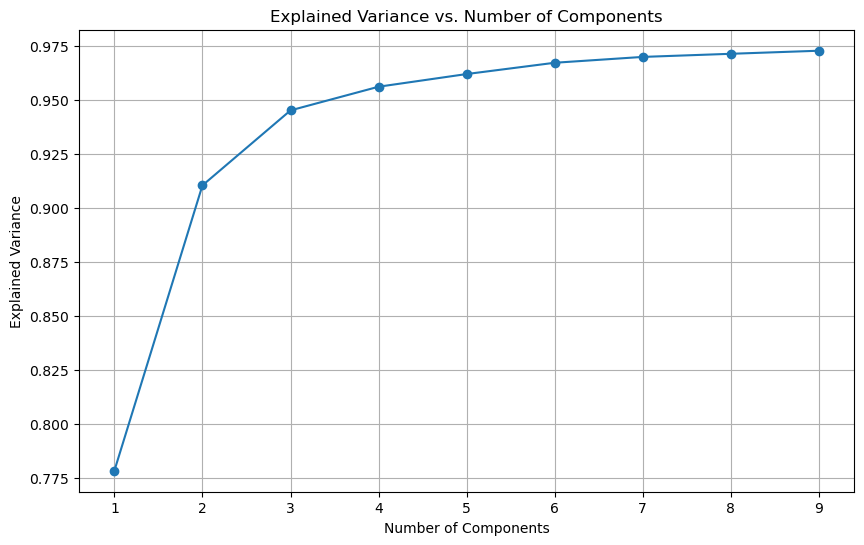

In [25]:
explained_variance = []

for n in range(1, 10):
    pca = PCA(n_components=n)
    pca.fit(combined_data_2d)
    explained_variance.append(np.sum(pca.explained_variance_ratio_))

# Plot the explained variance as a function of the number of components
plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

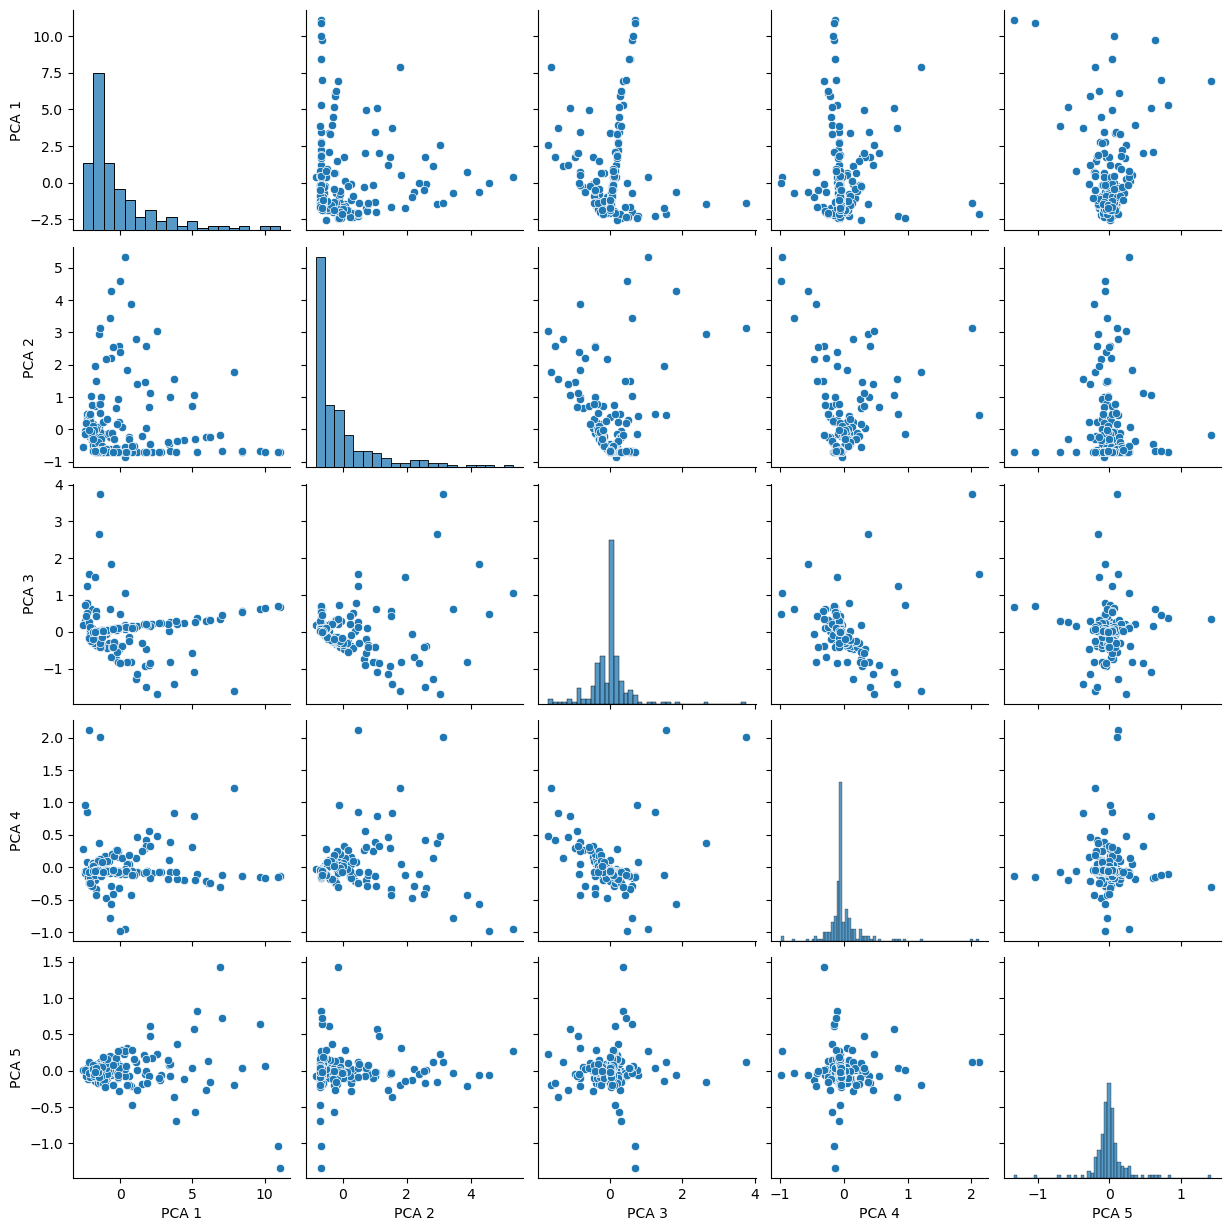

In [10]:
# Fit PCA with 5 components
n_components = 5
pca = PCA(n_components=n_components)
pca.fit(combined_data_2d)

# Transform data to the first 5 PCA components
transformed_data = pca.transform(combined_data_2d)

# Create a DataFrame with the transformed data
pca_df = pd.DataFrame(transformed_data, columns=[f"PCA {i + 1}" for i in range(n_components)])

# Create a pairplot
sns.pairplot(pca_df)
plt.show()
